In [1]:
!pwd

/mnt


In [3]:
import xarray as xr
import numpy as np
ds_dmsp = xr.open_dataset('/mnt/dmsp_2012_austin.nc').constant
ds_viirs = xr.open_dataset('/mnt/viirs_2012_austin.nc').avg_rad

In [5]:
x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)

In [6]:
import numpy as np

def unpatchify(patches, img_shape):
    patch_size = patches.shape[1]
    assert patches.shape[0] == (img_shape[0] // patch_size) * (img_shape[1] // patch_size), "Patches and image shape are not compatible"

    img = np.zeros(img_shape, dtype=patches.dtype)
    patch_idx = 0

    for i in range(0, img_shape[0], patch_size):
        for j in range(0, img_shape[1], patch_size):
            img[i:i + patch_size, j:j + patch_size] = patches[patch_idx]
            patch_idx += 1

    return img

def patchify(img, patch_size):
    img_shape = img.shape
    patches = np.array([img[i:i + patch_size, j:j + patch_size] for i in range(0, img_shape[0], patch_size) for j in range(0, img_shape[1], patch_size)])
    return patches

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
class ncDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = torch.from_numpy(self.data[index]).unsqueeze(0)
        y = torch.from_numpy(self.targets[index]).unsqueeze(0)
        # x = self.data[index]
        # y = self.targets[index]
        # x = x.to(dtype=torch.float32)
        # y = y.to(dtype=torch.float32)
        return x, y

    def __len__(self):
        return len(self.data)

In [8]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for batch in train_dataloader:
        lr, hr = batch
        lr, hr = lr.to(device), hr.to(device)
        optimizer.zero_grad()
        sr = model(lr)
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            lr, hr = batch
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)
            loss = criterion(sr, hr)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    return train_loss, val_loss

In [9]:
# Create patches from the image
patch_size = 32
img = x_train[:576,:576]
patches = patchify(img, patch_size)

In [10]:
# Reconstruct the image from the patches
reconstructed_img = unpatchify(patches, img.shape)

In [11]:
# Check if the reconstructed image is the same as the original image
assert np.allclose(reconstructed_img, img), "The reconstructed image is not the same as the original image"

In [12]:
x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:576,:576], patch_size)
y_train_patches = patchify(y_train[:576,:576], patch_size)
x_train_patches.shape

(324, 32, 32)

In [13]:
x_val_patches = x_train_patches[200:300]
y_val_patches = y_train_patches[200:300]

x_test_patches = x_train_patches[300:]
y_test_patches = y_train_patches[300:]

x_train_patches = x_train_patches[:200]

y_train_patches = y_train_patches[:200]

# SRCNN

In [14]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [15]:
train_dataset = ncDataset(x_train_patches, y_train_patches)
val_dataset = ncDataset(x_val_patches, y_val_patches)
test_dataset = ncDataset(x_val_patches, y_val_patches)

In [16]:
lr, hr = train_dataset.__getitem__(0)
print(lr.shape, hr.shape, train_dataset.__len__())

torch.Size([1, 32, 32]) torch.Size([1, 32, 32]) 200


In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

In [18]:
for batch in train_dataloader:
    data, targets = batch
    print(data.size())  # Should print torch.Size([16, 1, 30, 30])
    print(targets.size())  # Should print torch.Size([16, 1, 30, 601])
    break

torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])


In [19]:
# Initialize the model, loss function, and optimizer
device = 'cuda'
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
from copy import deepcopy

is_train = True
num_epochs = 1000
print_interval = 10
patience = 50
best_val_loss = float('inf')
counter = 0
best_model = None

if is_train:
    for epoch in range(1, num_epochs + 1):
        train_loss, val_loss = train(model, train_dataloader, val_dataloader, criterion, optimizer, device)
    # Log losses to TensorBoard
        #writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(model)
            counter = 0
        else:
            counter += 1

        if epoch % print_interval == 0:
            print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        if counter >= patience:
            print("Early stopping triggered.")
            break
    #writer.close()

Epoch [10/1000] - Train Loss: 0.0016, Validation Loss: 0.0096
Epoch [20/1000] - Train Loss: 0.0016, Validation Loss: 0.0098
Epoch [30/1000] - Train Loss: 0.0015, Validation Loss: 0.0085
Epoch [40/1000] - Train Loss: 0.0016, Validation Loss: 0.0085
Epoch [50/1000] - Train Loss: 0.0015, Validation Loss: 0.0081
Epoch [60/1000] - Train Loss: 0.0017, Validation Loss: 0.0083
Epoch [70/1000] - Train Loss: 0.0016, Validation Loss: 0.0080
Epoch [80/1000] - Train Loss: 0.0015, Validation Loss: 0.0089
Epoch [90/1000] - Train Loss: 0.0016, Validation Loss: 0.0087
Epoch [100/1000] - Train Loss: 0.0015, Validation Loss: 0.0103
Epoch [110/1000] - Train Loss: 0.0015, Validation Loss: 0.0089
Epoch [120/1000] - Train Loss: 0.0015, Validation Loss: 0.0077
Epoch [130/1000] - Train Loss: 0.0014, Validation Loss: 0.0082
Epoch [140/1000] - Train Loss: 0.0014, Validation Loss: 0.0087
Epoch [150/1000] - Train Loss: 0.0016, Validation Loss: 0.0091
Epoch [160/1000] - Train Loss: 0.0014, Validation Loss: 0.0102
E

# Diffusion

In [26]:
import torch
from diffusers import UNet2DModel, EDMEulerScheduler
from torch.optim import Adam
from tqdm import tqdm
# from datasets import load_dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import numpy as np

In [27]:
# Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# This work is licensed under a Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# You should have received a copy of the license along with this
# work. If not, see http://creativecommons.org/licenses/by-nc-sa/4.0/

"""Model architectures and preconditioning schemes used in the paper
"Elucidating the Design Space of Diffusion-Based Generative Models"."""

import numpy as np
import torch
from torch_utils import persistence
from torch.nn.functional import silu

#----------------------------------------------------------------------------
# Unified routine for initializing weights and biases.

def weight_init(shape, mode, fan_in, fan_out):
    if mode == 'xavier_uniform': return np.sqrt(6 / (fan_in + fan_out)) * (torch.rand(*shape) * 2 - 1)
    if mode == 'xavier_normal':  return np.sqrt(2 / (fan_in + fan_out)) * torch.randn(*shape)
    if mode == 'kaiming_uniform': return np.sqrt(3 / fan_in) * (torch.rand(*shape) * 2 - 1)
    if mode == 'kaiming_normal':  return np.sqrt(1 / fan_in) * torch.randn(*shape)
    raise ValueError(f'Invalid init mode "{mode}"')

#----------------------------------------------------------------------------
# Fully-connected layer.

# @persistence.persistent_class
class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True, init_mode='kaiming_normal', init_weight=1, init_bias=0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        init_kwargs = dict(mode=init_mode, fan_in=in_features, fan_out=out_features)
        self.weight = torch.nn.Parameter(weight_init([out_features, in_features], **init_kwargs) * init_weight)
        self.bias = torch.nn.Parameter(weight_init([out_features], **init_kwargs) * init_bias) if bias else None

    def forward(self, x):
        x = x @ self.weight.to(x.dtype).t()
        if self.bias is not None:
            x = x.add_(self.bias.to(x.dtype))
        return x

#----------------------------------------------------------------------------
# Convolutional layer with optional up/downsampling.

# @persistence.persistent_class
class Conv2d(torch.nn.Module):
    def __init__(self,
        in_channels, out_channels, kernel, bias=True, up=False, down=False,
        resample_filter=[1,1], fused_resample=False, init_mode='kaiming_normal', init_weight=1, init_bias=0,
    ):
        assert not (up and down)
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.up = up
        self.down = down
        self.fused_resample = fused_resample
        init_kwargs = dict(mode=init_mode, fan_in=in_channels*kernel*kernel, fan_out=out_channels*kernel*kernel)
        self.weight = torch.nn.Parameter(weight_init([out_channels, in_channels, kernel, kernel], **init_kwargs) * init_weight) if kernel else None
        self.bias = torch.nn.Parameter(weight_init([out_channels], **init_kwargs) * init_bias) if kernel and bias else None
        f = torch.as_tensor(resample_filter, dtype=torch.float32)
        f = f.ger(f).unsqueeze(0).unsqueeze(1) / f.sum().square()
        self.register_buffer('resample_filter', f if up or down else None)

    def forward(self, x):
        w = self.weight.to(x.dtype) if self.weight is not None else None
        b = self.bias.to(x.dtype) if self.bias is not None else None
        f = self.resample_filter.to(x.dtype) if self.resample_filter is not None else None
        w_pad = w.shape[-1] // 2 if w is not None else 0
        f_pad = (f.shape[-1] - 1) // 2 if f is not None else 0

        if self.fused_resample and self.up and w is not None:
            x = torch.nn.functional.conv_transpose2d(x, f.mul(4).tile([self.in_channels, 1, 1, 1]), groups=self.in_channels, stride=2, padding=max(f_pad - w_pad, 0))
            x = torch.nn.functional.conv2d(x, w, padding=max(w_pad - f_pad, 0))
        elif self.fused_resample and self.down and w is not None:
            x = torch.nn.functional.conv2d(x, w, padding=w_pad+f_pad)
            x = torch.nn.functional.conv2d(x, f.tile([self.out_channels, 1, 1, 1]), groups=self.out_channels, stride=2)
        else:
            if self.up:
                x = torch.nn.functional.conv_transpose2d(x, f.mul(4).tile([self.in_channels, 1, 1, 1]), groups=self.in_channels, stride=2, padding=f_pad)
            if self.down:
                x = torch.nn.functional.conv2d(x, f.tile([self.in_channels, 1, 1, 1]), groups=self.in_channels, stride=2, padding=f_pad)
            if w is not None:
                x = torch.nn.functional.conv2d(x, w, padding=w_pad)
        if b is not None:
            x = x.add_(b.reshape(1, -1, 1, 1))
        return x

#----------------------------------------------------------------------------
# Group normalization.

# @persistence.persistent_class
class GroupNorm(torch.nn.Module):
    def __init__(self, num_channels, num_groups=32, min_channels_per_group=4, eps=1e-5):
        super().__init__()
        self.num_groups = min(num_groups, num_channels // min_channels_per_group)
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.ones(num_channels))
        self.bias = torch.nn.Parameter(torch.zeros(num_channels))

    def forward(self, x):
        x = torch.nn.functional.group_norm(x, num_groups=self.num_groups, weight=self.weight.to(x.dtype), bias=self.bias.to(x.dtype), eps=self.eps)
        return x

#----------------------------------------------------------------------------
# Attention weight computation, i.e., softmax(Q^T * K).
# Performs all computation using FP32, but uses the original datatype for
# inputs/outputs/gradients to conserve memory.

class AttentionOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k):
        w = torch.einsum('ncq,nck->nqk', q.to(torch.float32), (k / np.sqrt(k.shape[1])).to(torch.float32)).softmax(dim=2).to(q.dtype)
        ctx.save_for_backward(q, k, w)
        return w

    @staticmethod
    def backward(ctx, dw):
        q, k, w = ctx.saved_tensors
        db = torch._softmax_backward_data(grad_output=dw.to(torch.float32), output=w.to(torch.float32), dim=2, input_dtype=torch.float32)
        dq = torch.einsum('nck,nqk->ncq', k.to(torch.float32), db).to(q.dtype) / np.sqrt(k.shape[1])
        dk = torch.einsum('ncq,nqk->nck', q.to(torch.float32), db).to(k.dtype) / np.sqrt(k.shape[1])
        return dq, dk

#----------------------------------------------------------------------------
# Unified U-Net block with optional up/downsampling and self-attention.
# Represents the union of all features employed by the DDPM++, NCSN++, and
# ADM architectures.

# @persistence.persistent_class
class UNetBlock(torch.nn.Module):
    def __init__(self,
        in_channels, out_channels, emb_channels, up=False, down=False, attention=False,
        num_heads=None, channels_per_head=64, dropout=0, skip_scale=1, eps=1e-5,
        resample_filter=[1,1], resample_proj=False, adaptive_scale=True,
        init=dict(), init_zero=dict(init_weight=0), init_attn=None,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.emb_channels = emb_channels
        self.num_heads = 0 if not attention else num_heads if num_heads is not None else out_channels // channels_per_head
        self.dropout = dropout
        self.skip_scale = skip_scale
        self.adaptive_scale = adaptive_scale

        self.norm0 = GroupNorm(num_channels=in_channels, eps=eps)
        self.conv0 = Conv2d(in_channels=in_channels, out_channels=out_channels, kernel=3, up=up, down=down, resample_filter=resample_filter, **init)
        self.affine = Linear(in_features=emb_channels, out_features=out_channels*(2 if adaptive_scale else 1), **init)
        self.norm1 = GroupNorm(num_channels=out_channels, eps=eps)
        self.conv1 = Conv2d(in_channels=out_channels, out_channels=out_channels, kernel=3, **init_zero)

        self.skip = None
        if out_channels != in_channels or up or down:
            kernel = 1 if resample_proj or out_channels!= in_channels else 0
            self.skip = Conv2d(in_channels=in_channels, out_channels=out_channels, kernel=kernel, up=up, down=down, resample_filter=resample_filter, **init)

        if self.num_heads:
            self.norm2 = GroupNorm(num_channels=out_channels, eps=eps)
            self.qkv = Conv2d(in_channels=out_channels, out_channels=out_channels*3, kernel=1, **(init_attn if init_attn is not None else init))
            self.proj = Conv2d(in_channels=out_channels, out_channels=out_channels, kernel=1, **init_zero)

    def forward(self, x, emb):
        orig = x
        x = self.conv0(silu(self.norm0(x)))

        params = self.affine(emb).unsqueeze(2).unsqueeze(3).to(x.dtype)
        if self.adaptive_scale:
            scale, shift = params.chunk(chunks=2, dim=1)
            x = silu(torch.addcmul(shift, self.norm1(x), scale + 1))
        else:
            x = silu(self.norm1(x.add_(params)))

        x = self.conv1(torch.nn.functional.dropout(x, p=self.dropout, training=self.training))
        x = x.add_(self.skip(orig) if self.skip is not None else orig)
        x = x * self.skip_scale

        if self.num_heads:
            q, k, v = self.qkv(self.norm2(x)).reshape(x.shape[0] * self.num_heads, x.shape[1] // self.num_heads, 3, -1).unbind(2)
            w = AttentionOp.apply(q, k)
            a = torch.einsum('nqk,nck->ncq', w, v)
            x = self.proj(a.reshape(*x.shape)).add_(x)
            x = x * self.skip_scale
        return x

#----------------------------------------------------------------------------
# Timestep embedding used in the DDPM++ and ADM architectures.

# @persistence.persistent_class
class PositionalEmbedding(torch.nn.Module):
    def __init__(self, num_channels, max_positions=10000, endpoint=False):
        super().__init__()
        self.num_channels = num_channels
        self.max_positions = max_positions
        self.endpoint = endpoint

    def forward(self, x):
        freqs = torch.arange(start=0, end=self.num_channels//2, dtype=torch.float32, device=x.device)
        freqs = freqs / (self.num_channels // 2 - (1 if self.endpoint else 0))
        freqs = (1 / self.max_positions) ** freqs
        x = x.ger(freqs.to(x.dtype))
        x = torch.cat([x.cos(), x.sin()], dim=1)
        return x

#----------------------------------------------------------------------------
# Timestep embedding used in the NCSN++ architecture.

# @persistence.persistent_class
class FourierEmbedding(torch.nn.Module):
    def __init__(self, num_channels, scale=16):
        super().__init__()
        self.register_buffer('freqs', torch.randn(num_channels // 2) * scale)

    def forward(self, x):
        x = x.ger((2 * np.pi * self.freqs).to(x.dtype))
        x = torch.cat([x.cos(), x.sin()], dim=1)
        return x

#----------------------------------------------------------------------------
# Reimplementation of the DDPM++ and NCSN++ architectures from the paper
# "Score-Based Generative Modeling through Stochastic Differential
# Equations". Equivalent to the original implementation by Song et al.,
# available at https://github.com/yang-song/score_sde_pytorch

# @persistence.persistent_class
class SongUNet(torch.nn.Module):
    def __init__(self,
        img_resolution,                     # Image resolution at input/output.
        in_channels,                        # Number of color channels at input.
        out_channels,                       # Number of color channels at output.
        label_dim           = 0,            # Number of class labels, 0 = unconditional.
        augment_dim         = 0,            # Augmentation label dimensionality, 0 = no augmentation.

        model_channels      = 128,          # Base multiplier for the number of channels.
        channel_mult        = [1,2,2,2],    # Per-resolution multipliers for the number of channels.
        channel_mult_emb    = 4,            # Multiplier for the dimensionality of the embedding vector.
        num_blocks          = 4,            # Number of residual blocks per resolution.
        attn_resolutions    = [16],         # List of resolutions with self-attention.
        dropout             = 0.10,         # Dropout probability of intermediate activations.
        label_dropout       = 0,            # Dropout probability of class labels for classifier-free guidance.

        embedding_type      = 'positional', # Timestep embedding type: 'positional' for DDPM++, 'fourier' for NCSN++.
        channel_mult_noise  = 1,            # Timestep embedding size: 1 for DDPM++, 2 for NCSN++.
        encoder_type        = 'standard',   # Encoder architecture: 'standard' for DDPM++, 'residual' for NCSN++.
        decoder_type        = 'standard',   # Decoder architecture: 'standard' for both DDPM++ and NCSN++.
        resample_filter     = [1,1],        # Resampling filter: [1,1] for DDPM++, [1,3,3,1] for NCSN++.
    ):
        assert embedding_type in ['fourier', 'positional']
        assert encoder_type in ['standard', 'skip', 'residual']
        assert decoder_type in ['standard', 'skip']

        super().__init__()
        self.label_dropout = label_dropout
        emb_channels = model_channels * channel_mult_emb
        noise_channels = model_channels * channel_mult_noise
        init = dict(init_mode='xavier_uniform')
        init_zero = dict(init_mode='xavier_uniform', init_weight=1e-5)
        init_attn = dict(init_mode='xavier_uniform', init_weight=np.sqrt(0.2))
        block_kwargs = dict(
            emb_channels=emb_channels, num_heads=1, dropout=dropout, skip_scale=np.sqrt(0.5), eps=1e-6,
            resample_filter=resample_filter, resample_proj=True, adaptive_scale=False,
            init=init, init_zero=init_zero, init_attn=init_attn,
        )

        # Mapping.
        self.map_noise = PositionalEmbedding(num_channels=noise_channels, endpoint=True) if embedding_type == 'positional' else FourierEmbedding(num_channels=noise_channels)
        self.map_label = Linear(in_features=label_dim, out_features=noise_channels, **init) if label_dim else None
        self.map_augment = Linear(in_features=augment_dim, out_features=noise_channels, bias=False, **init) if augment_dim else None
        self.map_layer0 = Linear(in_features=noise_channels, out_features=emb_channels, **init)
        self.map_layer1 = Linear(in_features=emb_channels, out_features=emb_channels, **init)

        # Encoder.
        self.enc = torch.nn.ModuleDict()
        cout = in_channels
        caux = in_channels
        for level, mult in enumerate(channel_mult):
            res = img_resolution >> level
            if level == 0:
                cin = cout
                cout = model_channels
                self.enc[f'{res}x{res}_conv'] = Conv2d(in_channels=cin, out_channels=cout, kernel=3, **init)
            else:
                self.enc[f'{res}x{res}_down'] = UNetBlock(in_channels=cout, out_channels=cout, down=True, **block_kwargs)
                if encoder_type == 'skip':
                    self.enc[f'{res}x{res}_aux_down'] = Conv2d(in_channels=caux, out_channels=caux, kernel=0, down=True, resample_filter=resample_filter)
                    self.enc[f'{res}x{res}_aux_skip'] = Conv2d(in_channels=caux, out_channels=cout, kernel=1, **init)
                if encoder_type == 'residual':
                    self.enc[f'{res}x{res}_aux_residual'] = Conv2d(in_channels=caux, out_channels=cout, kernel=3, down=True, resample_filter=resample_filter, fused_resample=True, **init)
                    caux = cout
            for idx in range(num_blocks):
                cin = cout
                cout = model_channels * mult
                attn = (res in attn_resolutions)
                self.enc[f'{res}x{res}_block{idx}'] = UNetBlock(in_channels=cin, out_channels=cout, attention=attn, **block_kwargs)
        skips = [block.out_channels for name, block in self.enc.items() if 'aux' not in name]

        # Decoder.
        self.dec = torch.nn.ModuleDict()
        for level, mult in reversed(list(enumerate(channel_mult))):
            res = img_resolution >> level
            if level == len(channel_mult) - 1:
                self.dec[f'{res}x{res}_in0'] = UNetBlock(in_channels=cout, out_channels=cout, attention=True, **block_kwargs)
                self.dec[f'{res}x{res}_in1'] = UNetBlock(in_channels=cout, out_channels=cout, **block_kwargs)
            else:
                self.dec[f'{res}x{res}_up'] = UNetBlock(in_channels=cout, out_channels=cout, up=True, **block_kwargs)
            for idx in range(num_blocks + 1):
                cin = cout + skips.pop()
                cout = model_channels * mult
                attn = (idx == num_blocks and res in attn_resolutions)
                self.dec[f'{res}x{res}_block{idx}'] = UNetBlock(in_channels=cin, out_channels=cout, attention=attn, **block_kwargs)
            if decoder_type == 'skip' or level == 0:
                if decoder_type == 'skip' and level < len(channel_mult) - 1:
                    self.dec[f'{res}x{res}_aux_up'] = Conv2d(in_channels=out_channels, out_channels=out_channels, kernel=0, up=True, resample_filter=resample_filter)
                self.dec[f'{res}x{res}_aux_norm'] = GroupNorm(num_channels=cout, eps=1e-6)
                self.dec[f'{res}x{res}_aux_conv'] = Conv2d(in_channels=cout, out_channels=out_channels, kernel=3, **init_zero)

    def forward(self, x, noise_labels, class_labels, augment_labels=None):
        # Mapping.
        emb = self.map_noise(noise_labels)
        emb = emb.reshape(emb.shape[0], 2, -1).flip(1).reshape(*emb.shape) # swap sin/cos
        if self.map_label is not None:
            tmp = class_labels
            if self.training and self.label_dropout:
                tmp = tmp * (torch.rand([x.shape[0], 1], device=x.device) >= self.label_dropout).to(tmp.dtype)
            emb = emb + self.map_label(tmp * np.sqrt(self.map_label.in_features))
        if self.map_augment is not None and augment_labels is not None:
            emb = emb + self.map_augment(augment_labels)
        emb = silu(self.map_layer0(emb))
        emb = silu(self.map_layer1(emb))

        # Encoder.
        skips = []
        aux = x
        for name, block in self.enc.items():
            if 'aux_down' in name:
                aux = block(aux)
            elif 'aux_skip' in name:
                x = skips[-1] = x + block(aux)
            elif 'aux_residual' in name:
                x = skips[-1] = aux = (x + block(aux)) / np.sqrt(2)
            else:
                x = block(x, emb) if isinstance(block, UNetBlock) else block(x)
                skips.append(x)

        # Decoder.
        aux = None
        tmp = None
        for name, block in self.dec.items():
            if 'aux_up' in name:
                aux = block(aux)
            elif 'aux_norm' in name:
                tmp = block(x)
            elif 'aux_conv' in name:
                tmp = block(silu(tmp))
                aux = tmp if aux is None else tmp + aux
            else:
                if x.shape[1] != block.in_channels:
                    x = torch.cat([x, skips.pop()], dim=1)
                x = block(x, emb)
        return aux

#----------------------------------------------------------------------------
# Reimplementation of the ADM architecture from the paper
# "Diffusion Models Beat GANS on Image Synthesis". Equivalent to the
# original implementation by Dhariwal and Nichol, available at
# https://github.com/openai/guided-diffusion

# @persistence.persistent_class
class DhariwalUNet(torch.nn.Module):
    def __init__(self,
        img_resolution,                     # Image resolution at input/output.
        in_channels,                        # Number of color channels at input.
        out_channels,                       # Number of color channels at output.
        label_dim           = 0,            # Number of class labels, 0 = unconditional.
        augment_dim         = 0,            # Augmentation label dimensionality, 0 = no augmentation.

        model_channels      = 192,          # Base multiplier for the number of channels.
        channel_mult        = [1,2,3,4],    # Per-resolution multipliers for the number of channels.
        channel_mult_emb    = 4,            # Multiplier for the dimensionality of the embedding vector.
        num_blocks          = 3,            # Number of residual blocks per resolution.
        attn_resolutions    = [32,16,8],    # List of resolutions with self-attention.
        dropout             = 0.10,         # List of resolutions with self-attention.
        label_dropout       = 0,            # Dropout probability of class labels for classifier-free guidance.
    ):
        super().__init__()
        self.label_dropout = label_dropout
        emb_channels = model_channels * channel_mult_emb
        init = dict(init_mode='kaiming_uniform', init_weight=np.sqrt(1/3), init_bias=np.sqrt(1/3))
        init_zero = dict(init_mode='kaiming_uniform', init_weight=0, init_bias=0)
        block_kwargs = dict(emb_channels=emb_channels, channels_per_head=64, dropout=dropout, init=init, init_zero=init_zero)

        # Mapping.
        self.map_noise = PositionalEmbedding(num_channels=model_channels)
        self.map_augment = Linear(in_features=augment_dim, out_features=model_channels, bias=False, **init_zero) if augment_dim else None
        self.map_layer0 = Linear(in_features=model_channels, out_features=emb_channels, **init)
        self.map_layer1 = Linear(in_features=emb_channels, out_features=emb_channels, **init)
        self.map_label = Linear(in_features=label_dim, out_features=emb_channels, bias=False, init_mode='kaiming_normal', init_weight=np.sqrt(label_dim)) if label_dim else None

        # Encoder.
        self.enc = torch.nn.ModuleDict()
        cout = in_channels
        for level, mult in enumerate(channel_mult):
            res = img_resolution >> level
            if level == 0:
                cin = cout
                cout = model_channels * mult
                self.enc[f'{res}x{res}_conv'] = Conv2d(in_channels=cin, out_channels=cout, kernel=3, **init)
            else:
                self.enc[f'{res}x{res}_down'] = UNetBlock(in_channels=cout, out_channels=cout, down=True, **block_kwargs)
            for idx in range(num_blocks):
                cin = cout
                cout = model_channels * mult
                self.enc[f'{res}x{res}_block{idx}'] = UNetBlock(in_channels=cin, out_channels=cout, attention=(res in attn_resolutions), **block_kwargs)
        skips = [block.out_channels for block in self.enc.values()]

        # Decoder.
        self.dec = torch.nn.ModuleDict()
        for level, mult in reversed(list(enumerate(channel_mult))):
            res = img_resolution >> level
            if level == len(channel_mult) - 1:
                self.dec[f'{res}x{res}_in0'] = UNetBlock(in_channels=cout, out_channels=cout, attention=True, **block_kwargs)
                self.dec[f'{res}x{res}_in1'] = UNetBlock(in_channels=cout, out_channels=cout, **block_kwargs)
            else:
                self.dec[f'{res}x{res}_up'] = UNetBlock(in_channels=cout, out_channels=cout, up=True, **block_kwargs)
            for idx in range(num_blocks + 1):
                cin = cout + skips.pop()
                cout = model_channels * mult
                self.dec[f'{res}x{res}_block{idx}'] = UNetBlock(in_channels=cin, out_channels=cout, attention=(res in attn_resolutions), **block_kwargs)
        self.out_norm = GroupNorm(num_channels=cout)
        self.out_conv = Conv2d(in_channels=cout, out_channels=out_channels, kernel=3, **init_zero)

    def forward(self, x, noise_labels, class_labels, augment_labels=None):
        # Mapping.
        emb = self.map_noise(noise_labels)
        if self.map_augment is not None and augment_labels is not None:
            emb = emb + self.map_augment(augment_labels)
        emb = silu(self.map_layer0(emb))
        emb = self.map_layer1(emb)
        if self.map_label is not None:
            tmp = class_labels
            if self.training and self.label_dropout:
                tmp = tmp * (torch.rand([x.shape[0], 1], device=x.device) >= self.label_dropout).to(tmp.dtype)
            emb = emb + self.map_label(tmp)
        emb = silu(emb)

        # Encoder.
        skips = []
        for block in self.enc.values():
            x = block(x, emb) if isinstance(block, UNetBlock) else block(x)
            skips.append(x)

        # Decoder.
        for block in self.dec.values():
            if x.shape[1] != block.in_channels:
                x = torch.cat([x, skips.pop()], dim=1)
            x = block(x, emb)
        x = self.out_conv(silu(self.out_norm(x)))
        return x

#----------------------------------------------------------------------------
# Preconditioning corresponding to the variance preserving (VP) formulation
# from the paper "Score-Based Generative Modeling through Stochastic
# Differential Equations".

# @persistence.persistent_class
class VPPrecond(torch.nn.Module):
    def __init__(self,
        img_resolution,                 # Image resolution.
        img_channels,                   # Number of color channels.
        label_dim       = 0,            # Number of class labels, 0 = unconditional.
        use_fp16        = False,        # Execute the underlying model at FP16 precision?
        beta_d          = 19.9,         # Extent of the noise level schedule.
        beta_min        = 0.1,          # Initial slope of the noise level schedule.
        M               = 1000,         # Original number of timesteps in the DDPM formulation.
        epsilon_t       = 1e-5,         # Minimum t-value used during training.
        model_type      = 'SongUNet',   # Class name of the underlying model.
        **model_kwargs,                 # Keyword arguments for the underlying model.
    ):
        super().__init__()
        self.img_resolution = img_resolution
        self.img_channels = img_channels
        self.label_dim = label_dim
        self.use_fp16 = use_fp16
        self.beta_d = beta_d
        self.beta_min = beta_min
        self.M = M
        self.epsilon_t = epsilon_t
        self.sigma_min = float(self.sigma(epsilon_t))
        self.sigma_max = float(self.sigma(1))
        self.model = globals()[model_type](img_resolution=img_resolution, in_channels=img_channels, out_channels=img_channels, label_dim=label_dim, **model_kwargs)

    def forward(self, x, sigma, class_labels=None, force_fp32=False, **model_kwargs):
        x = x.to(torch.float32)
        sigma = sigma.to(torch.float32).reshape(-1, 1, 1, 1)
        class_labels = None if self.label_dim == 0 else torch.zeros([1, self.label_dim], device=x.device) if class_labels is None else class_labels.to(torch.float32).reshape(-1, self.label_dim)
        dtype = torch.float16 if (self.use_fp16 and not force_fp32 and x.device.type == 'cuda') else torch.float32

        c_skip = 1
        c_out = -sigma
        c_in = 1 / (sigma ** 2 + 1).sqrt()
        c_noise = (self.M - 1) * self.sigma_inv(sigma)

        F_x = self.model((c_in * x).to(dtype), c_noise.flatten(), class_labels=class_labels, **model_kwargs)
        assert F_x.dtype == dtype
        D_x = c_skip * x + c_out * F_x.to(torch.float32)
        return D_x

    def sigma(self, t):
        t = torch.as_tensor(t)
        return ((0.5 * self.beta_d * (t ** 2) + self.beta_min * t).exp() - 1).sqrt()

    def sigma_inv(self, sigma):
        sigma = torch.as_tensor(sigma)
        return ((self.beta_min ** 2 + 2 * self.beta_d * (1 + sigma ** 2).log()).sqrt() - self.beta_min) / self.beta_d

    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)

#----------------------------------------------------------------------------
# Preconditioning corresponding to the variance exploding (VE) formulation
# from the paper "Score-Based Generative Modeling through Stochastic
# Differential Equations".

# @persistence.persistent_class
class VEPrecond(torch.nn.Module):
    def __init__(self,
        img_resolution,                 # Image resolution.
        img_channels,                   # Number of color channels.
        label_dim       = 0,            # Number of class labels, 0 = unconditional.
        use_fp16        = False,        # Execute the underlying model at FP16 precision?
        sigma_min       = 0.02,         # Minimum supported noise level.
        sigma_max       = 100,          # Maximum supported noise level.
        model_type      = 'SongUNet',   # Class name of the underlying model.
        **model_kwargs,                 # Keyword arguments for the underlying model.
    ):
        super().__init__()
        self.img_resolution = img_resolution
        self.img_channels = img_channels
        self.label_dim = label_dim
        self.use_fp16 = use_fp16
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.model = globals()[model_type](img_resolution=img_resolution, in_channels=img_channels, out_channels=img_channels, label_dim=label_dim, **model_kwargs)

    def forward(self, x, sigma, class_labels=None, force_fp32=False, **model_kwargs):
        x = x.to(torch.float32)
        sigma = sigma.to(torch.float32).reshape(-1, 1, 1, 1)
        class_labels = None if self.label_dim == 0 else torch.zeros([1, self.label_dim], device=x.device) if class_labels is None else class_labels.to(torch.float32).reshape(-1, self.label_dim)
        dtype = torch.float16 if (self.use_fp16 and not force_fp32 and x.device.type == 'cuda') else torch.float32

        c_skip = 1
        c_out = sigma
        c_in = 1
        c_noise = (0.5 * sigma).log()

        F_x = self.model((c_in * x).to(dtype), c_noise.flatten(), class_labels=class_labels, **model_kwargs)
        assert F_x.dtype == dtype
        D_x = c_skip * x + c_out * F_x.to(torch.float32)
        return D_x

    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)

#----------------------------------------------------------------------------
# Preconditioning corresponding to improved DDPM (iDDPM) formulation from
# the paper "Improved Denoising Diffusion Probabilistic Models".

# @persistence.persistent_class
class iDDPMPrecond(torch.nn.Module):
    def __init__(self,
        img_resolution,                     # Image resolution.
        img_channels,                       # Number of color channels.
        label_dim       = 0,                # Number of class labels, 0 = unconditional.
        use_fp16        = False,            # Execute the underlying model at FP16 precision?
        C_1             = 0.001,            # Timestep adjustment at low noise levels.
        C_2             = 0.008,            # Timestep adjustment at high noise levels.
        M               = 1000,             # Original number of timesteps in the DDPM formulation.
        model_type      = 'DhariwalUNet',   # Class name of the underlying model.
        **model_kwargs,                     # Keyword arguments for the underlying model.
    ):
        super().__init__()
        self.img_resolution = img_resolution
        self.img_channels = img_channels
        self.label_dim = label_dim
        self.use_fp16 = use_fp16
        self.C_1 = C_1
        self.C_2 = C_2
        self.M = M
        self.model = globals()[model_type](img_resolution=img_resolution, in_channels=img_channels, out_channels=img_channels*2, label_dim=label_dim, **model_kwargs)

        u = torch.zeros(M + 1)
        for j in range(M, 0, -1): # M, ..., 1
            u[j - 1] = ((u[j] ** 2 + 1) / (self.alpha_bar(j - 1) / self.alpha_bar(j)).clip(min=C_1) - 1).sqrt()
        self.register_buffer('u', u)
        self.sigma_min = float(u[M - 1])
        self.sigma_max = float(u[0])

    def forward(self, x, sigma, class_labels=None, force_fp32=False, **model_kwargs):
        x = x.to(torch.float32)
        sigma = sigma.to(torch.float32).reshape(-1, 1, 1, 1)
        class_labels = None if self.label_dim == 0 else torch.zeros([1, self.label_dim], device=x.device) if class_labels is None else class_labels.to(torch.float32).reshape(-1, self.label_dim)
        dtype = torch.float16 if (self.use_fp16 and not force_fp32 and x.device.type == 'cuda') else torch.float32

        c_skip = 1
        c_out = -sigma
        c_in = 1 / (sigma ** 2 + 1).sqrt()
        c_noise = self.M - 1 - self.round_sigma(sigma, return_index=True).to(torch.float32)

        F_x = self.model((c_in * x).to(dtype), c_noise.flatten(), class_labels=class_labels, **model_kwargs)
        assert F_x.dtype == dtype
        D_x = c_skip * x + c_out * F_x[:, :self.img_channels].to(torch.float32)
        return D_x

    def alpha_bar(self, j):
        j = torch.as_tensor(j)
        return (0.5 * np.pi * j / self.M / (self.C_2 + 1)).sin() ** 2

    def round_sigma(self, sigma, return_index=False):
        sigma = torch.as_tensor(sigma)
        index = torch.cdist(sigma.to(self.u.device).to(torch.float32).reshape(1, -1, 1), self.u.reshape(1, -1, 1)).argmin(2)
        result = index if return_index else self.u[index.flatten()].to(sigma.dtype)
        return result.reshape(sigma.shape).to(sigma.device)

#----------------------------------------------------------------------------
# Improved preconditioning proposed in the paper "Elucidating the Design
# Space of Diffusion-Based Generative Models" (EDM).

# @persistence.persistent_class
class EDMPrecond(torch.nn.Module):
    def __init__(self,
        img_resolution,                     # Image resolution.
        img_channels,                       # Number of color channels.
        label_dim       = 0,                # Number of class labels, 0 = unconditional.
        use_fp16        = False,            # Execute the underlying model at FP16 precision?
        sigma_min       = 0,                # Minimum supported noise level.
        sigma_max       = float('inf'),     # Maximum supported noise level.
        sigma_data      = 0.5,              # Expected standard deviation of the training data.
        model_type      = 'DhariwalUNet',   # Class name of the underlying model.
        **model_kwargs,                     # Keyword arguments for the underlying model.
    ):
        super().__init__()
        self.img_resolution = img_resolution
        self.img_channels = img_channels
        self.label_dim = label_dim
        self.use_fp16 = use_fp16
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.sigma_data = sigma_data
        self.model = globals()[model_type](img_resolution=img_resolution, in_channels=img_channels, out_channels=img_channels, label_dim=label_dim, **model_kwargs)

    def forward(self, x, sigma, class_labels=None, force_fp32=False, **model_kwargs):
        x = x.to(torch.float32)
        sigma = sigma.to(torch.float32).reshape(-1, 1, 1, 1)
        class_labels = None if self.label_dim == 0 else torch.zeros([1, self.label_dim], device=x.device) if class_labels is None else class_labels.to(torch.float32).reshape(-1, self.label_dim)
        dtype = torch.float16 if (self.use_fp16 and not force_fp32 and x.device.type == 'cuda') else torch.float32

        c_skip = self.sigma_data ** 2 / (sigma ** 2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4

        F_x = self.model((c_in * x).to(dtype), c_noise.flatten(), class_labels=class_labels, **model_kwargs)
        assert F_x.dtype == dtype
        D_x = c_skip * x + c_out * F_x.to(torch.float32)
        return D_x

    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)

#----------------------------------------------------------------------------

In [44]:
import torch
import torch.nn as nn
from diffusers import UNet2DModel

class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # The embedding layer will map the class label to a scalar value per pixel (like x)
        self.class_emb = nn.Embedding(num_classes, 28 * 28)  # Output size matches spatial dimensions

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information
        self.model = UNet2DModel(
            sample_size=28,           # the target image resolution
            in_channels=2,            # Additional input channel for class conditioning
            out_channels=1,           # the number of output channels
            layers_per_block=2,       # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64), 
            down_block_types=( 
                "DownBlock2D",        # a regular ResNet downsampling block
                "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ), 
            up_block_types=(
                "AttnUpBlock2D", 
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",          # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, class_labels):
        # Shape of x:
        bs, ch, w, h = x.shape
        
        # class conditioning is mapped to (bs, 1, 28, 28)
        class_cond = self.class_emb(class_labels)  # (bs, 28*28)
        class_cond = class_cond.view(bs, 1, 28, 28)  # Reshape to match input x
        
        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1)  # (bs, 2, 28, 28)

        # Feed this to the UNet alongside the timestep and return the prediction
        return self.model(net_input, t).sample  # (bs, 1, 28, 28)

In [45]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [ ]:
# How many runs through the data should we do?
n_epochs = 10

# Our network 
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []


In [38]:
# Define the model
class ConditionalSongUNet(nn.Module):
    def __init__(self, img_resolution=32, in_channels=1, out_channels=1, label_dim=10, model_channels=128):
        super().__init__()
        self.model = SongUNet(
            img_resolution=img_resolution,
            in_channels=in_channels + 1,  # Extra channel for class conditioning
            out_channels=out_channels,
            label_dim=label_dim,
            model_channels=model_channels
        )
        self.class_embedding = nn.Embedding(label_dim, img_resolution * img_resolution)
    
    def forward(self, x, timesteps, labels):
        class_emb = self.class_embedding(labels).view(x.shape[0], 1, x.shape[2], x.shape[3]).to(device)
        x_cond = torch.cat((x, class_emb), dim=1)  # Concatenate along channel dimension
        return self.model(x_cond, timesteps, labels)

In [39]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [40]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [41]:
# How many runs through the data should we do?
n_epochs = 10

# Initialize model and optimizer
net = ConditionalSongUNet().to(device)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Keeping a record of the losses for later viewing
losses = []

# Rough

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:06<00:00, 1531936.31it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 965740.23it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 6294830.80it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4813170.48it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 1, 4, 2, 0, 1, 0, 2])


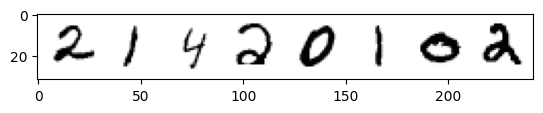

In [46]:

# Load the dataset
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [47]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()
    
    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64), 
        down_block_types=( 
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape
    
    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

100%|██████████| 469/469 [00:33<00:00, 13.94it/s]


Finished epoch 0. Average of the last 100 loss values: 0.052965


100%|██████████| 469/469 [00:33<00:00, 14.19it/s]


Finished epoch 1. Average of the last 100 loss values: 0.046416


100%|██████████| 469/469 [00:33<00:00, 14.05it/s]


Finished epoch 2. Average of the last 100 loss values: 0.044094


100%|██████████| 469/469 [00:33<00:00, 14.07it/s]


Finished epoch 3. Average of the last 100 loss values: 0.042591


100%|██████████| 469/469 [00:33<00:00, 14.02it/s]


Finished epoch 4. Average of the last 100 loss values: 0.041436


100%|██████████| 469/469 [00:33<00:00, 13.97it/s]


Finished epoch 5. Average of the last 100 loss values: 0.041199


100%|██████████| 469/469 [00:33<00:00, 13.93it/s]


Finished epoch 6. Average of the last 100 loss values: 0.040251


100%|██████████| 469/469 [00:33<00:00, 13.89it/s]


Finished epoch 7. Average of the last 100 loss values: 0.039607


100%|██████████| 469/469 [00:33<00:00, 13.88it/s]


Finished epoch 8. Average of the last 100 loss values: 0.038799


100%|██████████| 469/469 [00:33<00:00, 13.81it/s]

Finished epoch 9. Average of the last 100 loss values: 0.039131


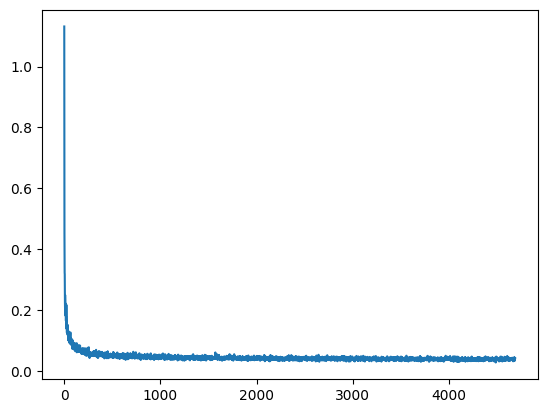

In [ ]:
# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network 
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        
        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

# Sampling

In [ ]:

#@markdown Sampling some different digits:

# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

# Now break the above code

In [68]:
class_emb_size = 1
model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64), 
        down_block_types=( 
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    ).to(device)

In [69]:
train_dataset = ncDataset(x_train_patches, y_train_patches)
val_dataset = ncDataset(x_val_patches, y_val_patches)
test_dataset = ncDataset(x_val_patches, y_val_patches)

In [70]:
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

In [74]:
for batch in train_dataloader:
    input, targets = batch
    print('Input.shape', input.size())  # Should print torch.Size([16, 1, 30, 30])
    print('Targets.shape', targets.size())  # Should print torch.Size([16, 1, 30, 601])
    x = input.to(device)  # Data on the GPU (mapped to (-1, 1))
    y = targets.to(device)
    noise = torch.randn_like(x)
    print('Noise.shape', noise.shape)
    timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
    print('Timesteps.shape, Timesteps:', timesteps.shape, timesteps)
    noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
    print('Noisy Input shape: ',noisy_x.shape)
    bs, ch, w, h = x.shape
    net_input = torch.cat((noisy_x, y), 1) # (bs, 2, 28, 28)
    print('Net input shape:', net_input.shape)
    pred = model(net_input, timesteps).sample
    print('Pred shape:', pred.shape)
# Calculate the loss
    loss = loss_fn(pred, noise) # How close is the output to the noise

    # Backprop and update the params:
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Store the loss for later
    losses.append(loss.item())

# # Print out the average of the last 100 loss values to get an idea of progress:
# avg_loss = sum(losses[-100:])/100
# print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

    break

Input.shape torch.Size([20, 1, 32, 32])
Targets.shape torch.Size([20, 1, 32, 32])
Noise.shape torch.Size([20, 1, 32, 32])
Timesteps.shape, Timesteps: torch.Size([20]) tensor([ 97, 975, 846, 116, 998, 511, 199, 737, 959,   6,  85, 149, 344, 915,
        527,  74, 204, 196, 413, 500], device='cuda:0')
Noisy Input shape:  torch.Size([20, 1, 32, 32])
Net input shape: torch.Size([20, 2, 32, 32])
Pred shape: torch.Size([20, 1, 32, 32])


# Sampling

# It is important to take guidance of the hyperparameters from the papers that have performed well 